## Campaign Response Prediction

**Business Goal**

The primary business goal is to enhance the effectiveness and return on investment (ROI) of future marketing campaigns. By accurately predicting which customers are most likely to respond to a promotional offer, the company can focus its marketing efforts and resources on high-probability leads, leading to higher conversion rates and a more efficient marketing spend.

**Key Predictive Features**

To predict whether a customer will respond to a campaign (the Response variable), the model leverages several categories of features:

* **Customer Demographics**: Core attributes like Age, Income, Education, and family structure (Total_Kids).
* **Spending Behavior**: Overall purchasing power, captured by engineered features like Total_Spent, and preferences shown by spending in specific categories (e.g., MntWines, MntMeatProducts).
* **Purchase Channel Engagement**: How and where customers shop, indicated by features like Total_Purchases, NumWebPurchase, and NumStorePurchase.
* **Customer Relationship & Loyalty**: The customer's history with the company, measured by Recency (days since last purchase) and Customer_Since_Days.
* **Past Campaign Performance**: A crucial set of predictors (AcceptedCmp1 through AcceptedCmp5) that show a customer's historical propensity to accept offers

In [1]:
## Import the necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.simplefilter("ignore")

# set up to view all the info of the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('./marketing data/marketing_data_with_features.csv')
df.head()

,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Age,Is_Parent,Total_Kids,Marital_Status_Simplified,Total_Spent,MntWines_Share,MntFruits_Share,MntMeatProducts_Share,MntFishProducts_Share,MntSweetProducts_Share,MntGoldProds_Share,Total_Purchases,Avg_Spend_per_Purchase,Deal_Rate,Web_Purchase_Share,Web_Visit_to_Purchase_Ratio,Is_Online_Buyer,Customer_Since_Days,Is_Active,Lifetime_Spend_per_Day,Total_Accepted_Campaigns,Campaign_Response_Rate,Is_Responder
0,1970,Graduation,84835,0,0,6/16/2014,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP,55,0,0,Single,1190,0.158824,0.087395,0.318487,0.093277,0.158824,0.183193,15,79.333333,0.066667,0.266667,0.200,0,3486,1,0.341365,0,0.0,1
1,1961,Graduation,57091,0,0,6/15/2014,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA,64,0,0,Single,577,0.804159,0.008666,0.110919,0.012132,0.000000,0.064125,18,32.055556,0.055556,0.388889,0.625,0,3487,1,0.165472,1,0.2,1
2,1958,Graduation,67267,0,1,5/13/2014,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US,67,1,1,Partnered,251,0.533865,0.043825,0.235060,0.059761,0.007968,0.119522,11,22.818182,0.090909,0.272727,0.500,0,3520,1,0.071307,0,0.0,0
3,1967,Graduation,32474,1,1,5/11/2014,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS,58,1,2,Partnered,11,0.909091,0.000000,0.090909,0.000000,0.000000,0.000000,4,2.750000,0.250000,0.250000,3.500,0,3522,1,0.003123,0,0.0,0
4,1989,Graduation,21474,1,0,4/8/2014,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP,36,1,1,Single,91,0.065934,0.175824,0.263736,0.120879,0.000000,0.373626,8,11.375000,0.250000,0.375000,1.750,1,3555,1,0.025598,1,0.2,1


##### **1. Feature Selection and Data Preprocessing:**

In [3]:
features = [
    'Income', 'Recency', 'Age', 'Total_Kids', 'Total_Spent', 'Total_Purchases', 'Customer_Since_Days',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
    'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain',
    'Education', 'Marital_Status_Simplified'
]

target = 'Response'

In [4]:
# Create a new dataframe with selected features and target
model_df = df[features + [target]].copy()
model_df.sample(5)

,Income,Recency,Age,Total_Kids,Total_Spent,Total_Purchases,Customer_Since_Days,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Education,Marital_Status_Simplified,Response
1141,50300,52,73,1,270,13,3508,143,15,60,24,23,5,2,2,1,8,2,0,0,0,0,0,0,Graduation,Partnered,0
1090,69142,50,73,1,535,19,3473,448,4,34,6,4,39,3,8,1,7,5,0,0,0,1,0,0,Graduation,Single,0
327,78687,13,42,0,2130,19,4162,817,185,687,145,55,241,1,4,6,8,2,0,0,0,0,1,0,Graduation,Partnered,1
475,50002,21,71,1,638,19,3850,443,5,71,21,16,82,2,8,2,7,7,0,0,0,0,0,0,Graduation,Single,0
492,89694,22,52,2,1472,14,3736,1126,28,211,37,28,42,3,4,3,4,5,1,0,0,1,1,0,Graduation,Single,0


In [5]:
model_df.Response.value_counts()

Response
0    1865
1     328
Name: count, dtype: int64

In [6]:
# One-Hot Encode categorical variables
categorical_cols = ['Education', 'Marital_Status_Simplified']
model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)

##### **2. Model Development**

In [7]:
# Define Features (X) and Target (y)
X = model_df.drop(target, axis=1)
y = model_df[target]
print('Features shape:', X.shape)
print('Target shape:', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Features shape: (2193, 30)
Target shape: (2193,)


In [8]:
print("y_train:", y_train.value_counts(), "\ny_test:", y_test.value_counts())

y_train: Response
0    1492
1     262
Name: count, dtype: int64 
y_test: Response
0    373
1     66
Name: count, dtype: int64


In [12]:
models = {
    "Logistic Regression (Baseline)": LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Loop through models, train, evaluate, and store results
for name, model in models.items():
    print(f"--- Evaluating: {name} ---")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)*100
    results[name] = accuracy
    
    print(f'Accuracy: {accuracy:.4f}%')
    print('Classification Report:')
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-" * 40)

--- Evaluating: Logistic Regression (Baseline) ---
Accuracy: 81.7768%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       373
           1       0.43      0.68      0.53        66

    accuracy                           0.82       439
   macro avg       0.69      0.76      0.71       439
weighted avg       0.86      0.82      0.83       439

----------------------------------------
--- Evaluating: Random Forest ---
Accuracy: 87.0159%
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       373
           1       0.70      0.24      0.36        66

    accuracy                           0.87       439
   macro avg       0.79      0.61      0.64       439
weighted avg       0.85      0.87      0.84       439

----------------------------------------
--- Evaluating: Gradient Boosting ---
Accuracy: 88.6105%
Classification Report:
              p

In [52]:
results

{'Logistic Regression (Baseline)': 76.08200455580865,
 'Random Forest': 87.01594533029613,
 'Gradient Boosting': 88.61047835990888,
 'AdaBoost': 87.47152619589977}

In [10]:
# Print summary of results
print("--- Model Comparison Summary ---")
# Sort models by accuracy
sorted_results = sorted(results.items(), key=lambda item: item[1], reverse=True)
for name, accuracy in sorted_results:
    print(f"{name}: {accuracy:.4f}")

--- Model Comparison Summary ---
Gradient Boosting: 88.6105
AdaBoost: 87.4715
Random Forest: 87.0159
Logistic Regression (Baseline): 76.0820


In [11]:
print("--- Feature Importance from Random Forest ---")
# You can access the trained model from the dictionary
rf_model = models["Random Forest"]
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print('Top 10 Most Important Features:')
print(importance_df.head(10))

--- Feature Importance from Random Forest ---
Top 10 Most Important Features:
                Feature  Importance
1               Recency    0.105562
6   Customer_Since_Days    0.084160
12         MntGoldProds    0.066308
0                Income    0.065842
4           Total_Spent    0.060546
9       MntMeatProducts    0.055128
7              MntWines    0.051958
15  NumCatalogPurchases    0.040104
20         AcceptedCmp3    0.037572
16    NumStorePurchases    0.037311


### Handling Imbalanced Target (Response) — experiments added
The cells below run several imbalance-handling strategies:
- Baseline with class-weighted models
- SMOTE oversampling (applied only on training folds via pipeline)
- Random undersampling
- SMOTE + Tomek links (cleanup)
- Balanced ensemble (BalancedBagging)
- Threshold tuning using Precision-Recall for deployment decisions

Run each cell to evaluate and compare PR-AUC / F1 / precision / recall. Make sure `imblearn` is installed (pip install imbalanced-learn) if not already.

In [29]:
# Quick: imports used across experiments
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# helper to evaluate models using cross-validated predicted probabilities
def evaluate_model_cv(model, X, y, cv=cv):
    probs = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:,1]
    preds = (probs >= 0.5).astype(int)
    precision, recall, _ = precision_recall_curve(y, probs)
    pr_auc = auc(recall, precision)
    return {
        'pr_auc': pr_auc,
        'f1': f1_score(y, preds),
        'precision': precision_score(y, preds),
        'recall': recall_score(y, preds)
    }

In [30]:
# 1) Baseline: class-weighted Logistic Regression and RandomForest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

baseline_lr = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42)
baseline_rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

print('Evaluating baseline Logistic Regression...')
res_lr = evaluate_model_cv(baseline_lr, X, y)
print('LR (class_weight) - PR AUC: {pr_auc:.4f}, F1: {f1:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}'.format(**res_lr))

print('Evaluating baseline Random Forest...')
res_rf = evaluate_model_cv(baseline_rf, X, y)
print('RF (class_weight) - PR AUC: {pr_auc:.4f}, F1: {f1:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}'.format(**res_rf))

Evaluating baseline Logistic Regression...
LR (class_weight) - PR AUC: 0.5912, F1: 0.5591, Prec: 0.4319, Recall: 0.7927
Evaluating baseline Random Forest...
RF (class_weight) - PR AUC: 0.5790, F1: 0.4045, Prec: 0.7692, Recall: 0.2744
RF (class_weight) - PR AUC: 0.5790, F1: 0.4045, Prec: 0.7692, Recall: 0.2744


In [31]:
# 2) SMOTE oversampling pipeline (train-only via pipeline)
pipeline_smote = ImbPipeline([('smote', SMOTE(random_state=42)),
                             ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])

res_smote = evaluate_model_cv(pipeline_smote, X, y)
print('SMOTE + RF - PR AUC: {pr_auc:.4f}, F1: {f1:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}'.format(**res_smote))

SMOTE + RF - PR AUC: 0.5203, F1: 0.5241, Prec: 0.5544, Recall: 0.4970


In [32]:
# 3) Random undersampling pipeline
pipeline_under = ImbPipeline([('under', RandomUnderSampler(random_state=42)),
                              ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])

res_under = evaluate_model_cv(pipeline_under, X, y)
print('Under + RF - PR AUC: {pr_auc:.4f}, F1: {f1:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}'.format(**res_under))

Under + RF - PR AUC: 0.5377, F1: 0.5210, Prec: 0.3792, Recall: 0.8323


In [33]:
# 4) SMOTE + Tomek (cleaning combined) pipeline
pipeline_smote_tomek = ImbPipeline([('smote_tomek', SMOTETomek(random_state=42)),
                                   ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])
res_smote_tomek = evaluate_model_cv(pipeline_smote_tomek, X, y)
print('SMOTE+Tomek + RF - PR AUC: {pr_auc:.4f}, F1: {f1:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}'.format(**res_smote_tomek))

SMOTE+Tomek + RF - PR AUC: 0.5223, F1: 0.5212, Prec: 0.5594, Recall: 0.4878


In [28]:
# 5) Balanced ensemble (BalancedBaggingClassifier) - good default for imbalance
bbc = BalancedBaggingClassifier(n_estimators=10, random_state=42,
                                estimator=RandomForestClassifier(n_estimators=50, random_state=42))
res_bbc = evaluate_model_cv(bbc, X, y)
print('BalancedBagging - PR AUC: {pr_auc:.4f}, F1: {f1:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}'.format(**res_bbc))

BalancedBagging - PR AUC: 0.5901, F1: 0.5494, Prec: 0.4376, Recall: 0.7378


Results (PR-AUC, F1, Precision, Recall)

Logistic Regression (class_weight): PR AUC = 0.5912, F1 = 0.5591, Precision = 0.4319, Recall = 0.7927
Random Forest (class_weight): PR AUC = 0.5790, F1 = 0.4045, Precision = 0.7692, Recall = 0.2744
SMOTE + RF: PR AUC = 0.5203, F1 = 0.5241, Precision = 0.5544, Recall = 0.4970
Under + RF: PR AUC = 0.5377, F1 = 0.5210, Precision = 0.3792, Recall = 0.8323
SMOTE+Tomek + RF: PR AUC = 0.5223, F1 = 0.5212, Precision = 0.5594, Recall = 0.4878
BalancedBagging (ensemble): PR AUC = 0.5901, F1 = 0.5494, Precision = 0.4376, Recall = 0.7378
Quick interpretation

The class-weighted Logistic Regression and the BalancedBagging ensemble show the best PR-AUC (~0.59). BalancedBagging has slightly higher F1 than LR, with similar recall and slightly higher precision for LR.
RandomForest with class_weight has high precision but very low recall (it’s conservative).
Undersampling yields high recall but low precision (trades precision for recall).
SMOTE variants are not outperforming the simpler class-weighted LR or the balanced ensemble on PR-AUC in this dataset/setting.
Recommended next steps

Decide business preference: favor recall (catch more responders) or favor precision (avoid wasting contact on false positives). If recall is prioritized, the undersampling pipeline looked promising; if balance or PR-AUC is prioritized, the BalancedBagging or class-weighted Logistic Regression are good candidates.
Threshold tuning: for the chosen model, compute the precision-recall curve on cross-validated probabilities and pick an operating threshold matching your desired precision/recall trade-off. I can add code cells to:
Plot PR curve for the chosen model,
Select a threshold that yields, for example, recall >= 0.7 while maximizing precision,
Re-evaluate final metrics on the hold-out test set (X_test / y_test).
Model calibration: consider calibrating probabilities (CalibratedClassifierCV) before threshold tuning if probabilities look poorly calibrated.

### Threshold tuning (recall-prioritized) and optional calibration

We prioritize recall (catch more responders). The following cells will:

1. Optionally calibrate model probabilities using CalibratedClassifierCV (recommended when probabilities are not well calibrated).
2. Use cross-validated predicted probabilities on the training set to compute the precision-recall curve.
3. Find the operating threshold that achieves recall >= 0.7 while maximizing precision.
4. Apply the selected threshold to the hold-out test set and report final metrics (precision, recall, F1, confusion matrix, and PR-AUC).

Run these cells to select an operating point tuned for recall-first business preference.

Calibrating classifier probabilities with isotonic calibration (may be slower)...
Cross-validated PR AUC (used for threshold search): 0.5977
Chosen threshold: 0.3070 with precision=0.4752, recall=0.7012


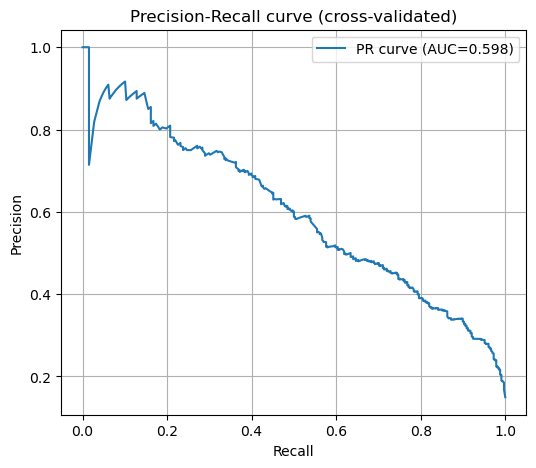

In [36]:
# Optional calibration + cross-validated probability generation and threshold selection (recall >= 0.7)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

# Choose the model to use for final tuning: BalancedBagging (bbc) performed well; we'll use it as default.
model_to_tune = bbc

# Optionally calibrate probabilities (set to True if you want to calibrate)
calibrate = True
if calibrate:
    print('Calibrating classifier probabilities with isotonic calibration (may be slower)...')
    calibrated = CalibratedClassifierCV(estimator=model_to_tune, method='isotonic', cv=3)
    # generate cross-validated probabilities (training-only) for threshold selection
    probs_cv = cross_val_predict(calibrated, X, y, cv=cv, method='predict_proba')[:,1]
else:
    # use cross-validated probs from the raw model
    probs_cv = cross_val_predict(model_to_tune, X, y, cv=cv, method='predict_proba')[:,1]

precision, recall, thresholds = precision_recall_curve(y, probs_cv)
pr_auc_cv = auc(recall, precision)
print(f'Cross-validated PR AUC (used for threshold search): {pr_auc_cv:.4f}')

# Find threshold(s) that meet recall >= 0.7, then pick the one with max precision among them
target_recall = 0.7
valid_idx = [i for i, r in enumerate(recall) if r >= target_recall]
if len(valid_idx) == 0:
    print(f'No threshold found with recall >= {target_recall}. Consider lowering the target or re-training.')
    best_threshold = 0.5
else:
    # thresholds array length is len(precision)-1; align indices appropriately
    # compute precision for thresholds indices
    # note: precision[i] corresponds to threshold[i] except last precision value which has no threshold
    thr_candidates = []
    for i in valid_idx:
        if i == len(thresholds):
            continue
        thr_candidates.append((thresholds[i], precision[i], recall[i]))
    # pick candidate with max precision
    best_threshold, best_prec, best_rec = max(thr_candidates, key=lambda x: x[1])
    print(f'Chosen threshold: {best_threshold:.4f} with precision={best_prec:.4f}, recall={best_rec:.4f}')

# Plot PR curve and vertical line at chosen threshold's point (approx)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc_cv:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (cross-validated)')
plt.grid(True)
plt.legend()
plt.show()

In [37]:
# Apply the chosen threshold to the hold-out test set and report final metrics
# Use the calibrated model if calibration was performed, otherwise use the raw fitted model (fit on full train)
from sklearn.base import clone

# Fit the selected model on the full training data
if calibrate:
    final_model = CalibratedClassifierCV(estimator=model_to_tune, method='isotonic', cv=3)
else:
    final_model = clone(model_to_tune)

# Fit on training data only
final_model.fit(X_train, y_train)
probs_test = final_model.predict_proba(X_test)[:,1]

# Apply selected threshold
threshold = best_threshold if 'best_threshold' in globals() else 0.5
y_pred_thresh = (probs_test >= threshold).astype(int)

# Print final metrics
final_pr_precision, final_pr_recall, _ = precision_recall_curve(y_test, probs_test)
final_pr_auc = auc(final_pr_recall, final_pr_precision)
print(f'Final PR AUC (test): {final_pr_auc:.4f}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_thresh))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_thresh, zero_division=0))
print(f'Operating threshold used: {threshold:.4f}')

Final PR AUC (test): 0.5727
Confusion Matrix:
[[341  32]
 [ 30  36]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       373
           1       0.53      0.55      0.54        66

    accuracy                           0.86       439
   macro avg       0.72      0.73      0.73       439
weighted avg       0.86      0.86      0.86       439

Operating threshold used: 0.3070
